# Note
This interactive notebook contains the code for Protein-Protein interaction prediction context which was adapted from the MHC-Peptide context. Full scripts are located in the github here: [https://github.com/jishnu-lab/SWING]

# Imports and Data

In [1]:
import pandas as pd # For data handling
import numpy as np
import os
import random
random.seed(42)
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import sklearn
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, auc
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

df = pd.read_csv('../Data/MutInt_Model/Mutation_perturbation_model.csv')

df.shape

/ihome/djishnu/jcsiwe/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/ihome/djishnu/jcsiwe/.local/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


(12612, 13)

In [2]:
df.head(10)

,Target_UPID,Mutation,Y2H_score,Before_AA,Position,After_AA,Interactor_UPID,Target_Seq,Interactor_Seq,Mutated_Seq (unless WT),Data,Type,Category
0,P62195-1,R60Q,0,R,60,Q,O76015,MALDGPEQMELEEGKAGSGLRQYYLSKIEELQLIVNDKSQNLRRLQ...,MTSSYSSSSCPLGCTMAPGARNVSVSPIDIGCQPGAEANIAPMCLL...,MALDGPEQMELEEGKAGSGLRQYYLSKIEELQLIVNDKSQNLRRLQ...,nature,WildType,NaN
1,Q13490,V77L,0,V,77,L,Q13490,MHKTASQRLFPGPSYQNIKSIMEDSTILSDWTNSNKQKMKYDFSCE...,MHKTASQRLFPGPSYQNIKSIMEDSTILSDWTNSNKQKMKYDFSCE...,MHKTASQRLFPGPSYQNIKSIMEDSTILSDWTNSNKQKMKYDFSCE...,nature,WildType,NaN
2,Q9NX47,D202N,0,D,202,N,X6REH9,MPDQALQQMLDRSCWVCFATDEDDRTAEWVRPCRCRGSTKWVHQAC...,MLSPRGVTRARQLLPLRLWPRRSWGDGSIMASMQTTGRRVEVWFPK...,MPDQALQQMLDRSCWVCFATDEDDRTAEWVRPCRCRGSTKWVHQAC...,nature,Mutant,NaN
3,P30281,E253D,0,E,253,D,P38936,MELLCCEGTRHAPRAGPDPRLLGDQRVLQSLLRLEERYVPRASYFQ...,MSEPAGDVRQNPCGSKACRRLFGPVDSEQLSRDCDALMAGCIQEAR...,MELLCCEGTRHAPRAGPDPRLLGDQRVLQSLLRLEERYVPRASYFQ...,nature,Mutant,NaN
4,Q08426,L715S,0,L,715,S,B7Z8K2,MAEYTRLHNALALIRLRNPPVNAISTTLLRDIKEGLQKAVIDHTIK...,MEGRGPYRIYDPGGSVPSGEASAAFERLVKENSRLKEKMQGIKMLG...,MAEYTRLHNALALIRLRNPPVNAISTTLLRDIKEGLQKAVIDHTIK...,nature,WildType,NaN
5,O75603,D53N,0,D,53,N,O43186,MPAAAVQEAVGVCSYGMQLSWDINDPQMPQELALFDQFREWPDGYV...,MMAYMNPGPHYSVNALALSGPSVDLMHQAVPYPSAPRKQRRERTTF...,MPAAAVQEAVGVCSYGMQLSWDINDPQMPQELALFDQFREWPDGYV...,nature,WildType,NaN
6,O95630,R255H,0,R,255,H,Q15645,MSDHGDVSLPPEDRVRALSQLGSAVEVNEDIPPRRYFRSGVEIIRM...,MDEAVGDLKQALPCVAESPTVHVEVHQRGSSTAKKEDINLSVRKLL...,MSDHGDVSLPPEDRVRALSQLGSAVEVNEDIPPRRYFRSGVEIIRM...,nature,Mutant,NaN
7,Q8N5R6-5,G196R,0,G,196,R,Q9Y5V3,MGEPGPPSPPAPKAAPGLIDSFSEMNNYRRAMQKMAEDILSLRRQA...,MAQKMDCGAGLLGFQAEASVEDSALLMQTLMEAIQISEAPPTNQAT...,MGEPGPPSPPAPKAAPGLIDSFSEMNNYRRAMQKMAEDILSLRRQA...,nature,WildType,NaN
8,O00267,E455D,0,E,455,D,P63272,MSDSEDSNFSEEEDSERSSDGEEAEVDEERRSAAGSEKEEEPEDEE...,MALETVPKDLRHLRACLLCSLVKTIDQFEYDGCDNCDAYLQMKGNR...,MSDSEDSNFSEEEDSERSSDGEEAEVDEERRSAAGSEKEEEPEDEE...,nature,WildType,NaN
9,Q8WWY3,L107V,0,L,107,V,A0A3B0J271,MSLADELLADLEEAAEEEEGGSYGEEEEEPAIEDVQEETQLDLSGD...,MCVECVHVWGLHVCECVCMCVCARECVVSACMHAWVCESDCPPRSC...,MSLADELLADLEEAAEEEEGGSYGEEEEEPAIEDVQEETQLDLSGD...,np,Mutant,Disease mutation


# Language Generation
Packages needed:
- pandas
- numpy
- random
- gensim.models.doc2vec's Doc2Vec and TaggedDocument

## Delta Grantham Dict

In [3]:
AA_scores = {'A':8.1,'R':10.5,'N':11.6,'D':13.0,'C':5.5,'E':12.3,'Q':10.5,'G':9.0,'H':10.4,'I':5.2,
            'L':4.9,'K':11.3,'M':5.7,'F':5.2,'P':8.0,'S':9.2,'T':8.6,'W':5.4,'Y':6.2,'V':5.9} # Grantham score, interchangable
AAs = list(AA_scores.keys())
aa_score_dict = {} 
for i in range(len(AAs)): # create all pairs of AAs
    for j in range(len(AAs)-i):
        AA_pair = AAs[i]+AAs[j+i]
        AA_pair_score = round(abs(AA_scores[AAs[i]]-AA_scores[AAs[j+i]])) # take rounded, absolute value of the difference of scores
        aa_score_dict[AA_pair] = AA_pair_score # forward
        aa_score_dict[AA_pair[::-1]] = AA_pair_score # and reverse

## Window Encodings

### README
get_window_encodings() takes a pandas dataframe where each row represents a protein-protein interaction with an position of mutation (integers) column, mutated sequence column (string), and interactor sequence column (string). It also takes a window_k parameter (integer) which determines the number of amino acids of each side of the mutation to include in the mutation window. The scoring method is input as a dictionary with interacting amino acids (str) as keys and the absolute value of the rounded difference of the scores (Ex. 'AR':2). The padding score is also a parameter (integer) and should be based on the range of score differences. 

The function returns a list of score encodings strings that each represent a PPI. The ends of the encodings include padding from the sliding window process. These encodings will be broken into k-mers for the embedding model.

In [4]:
def get_window_encodings(df, window_k=1, pos_colname='Position', mutseq_colname='Mutated_Seq (unless WT)', intseq_colname='Interactor_Seq', aa_score_dict=aa_score_dict, padding_score=9): # Takes df (mut/int sequences and mutation position) and window_k (# AA's on each side of the mutation position)
    total_encodings = [] # Master list of encodings
    for i in tqdm(df.index): # Iterate through protein pairs
        pos = df[pos_colname].iloc[i]-1 # find mutation position for window
        mut_window = df[mutseq_colname].iloc[i][pos-window_k:pos+window_k+1] # Create sliding window
        interactor = df[intseq_colname].iloc[i] # Get interactor sequence
        PPI_encoding = '' # For each PPI
        its = 0 # Tracks sliding window position
        for j in range(len(interactor)): # For the entire length of the interactor
            window_scores = '' # Saves the scores between window-interactor at the 'its' position
            for k in range(len(mut_window)): # At each positon of the interactor ('its'), align mutant window and find the score differences
                try: # If 'its' is at the end of the interactor, the window is hanging off end (padding)
                    pair = mut_window[k]+interactor[k+its] 
                    score = aa_score_dict[pair]
                except: # If not a pair, its padding (end of interactor)
                    pair = None
                    score = padding_score # Padding score is 9
                window_scores = window_scores + str(score) # Add score to running string
            its +=1 # Slide down a position on the interactor
            PPI_encoding = PPI_encoding + str(window_scores) # Add to final string for interaction
        total_encodings.append(PPI_encoding) # Add to list for all interactions
    return total_encodings # List of encodings for each PPI

In [5]:
window_encodings = get_window_encodings(df, window_k=1, pos_colname='Position', mutseq_colname='Mutated_Seq (unless WT)', intseq_colname='Interactor_Seq', aa_score_dict=aa_score_dict, padding_score=9)
# window_encodings[0] # last SW 2999999 (2*window_k+1)

100%|██████████| 12612/12612 [00:03<00:00, 3484.99it/s]


## K-Mers

### README
get_kmers_str() takes the encoding scores from get_window_encodings(), a k parameter that represents the k-mer size (integer) and the same padding_score (integer) from get_window_encodings(). 


This function returns a list of lists of overlapping k-mers of specified size k, removing k-mers of only padding. Each list of k-mers are specific to each of the PPIs.

In [6]:
def get_kmers_str(encoding_scores, k=7, padding_score=9):
    padding = {str(padding_score)} 
    for i in range(k): # Makes a set of padding scores that will be removed from the final k-mers
        padding.add(str(padding_score)*(i+1)) # {'9','99','999'...}
    kmers = [] # Master list of k-mers
    for ppi_score in tqdm(encoding_scores): # For each PPI encoding
        int_kmers = [] # K-mers specific to PPI
        for j in range(len(ppi_score)): # Iterate over the PPI encoding
            kmer = ppi_score[j:j+k] # Slice k-mers and sliding over
            if kmer in padding: # If K-mer is just padding, don't add it
                pass
            else:
                int_kmers.append(kmer) # Keep non-padding k-mers  
        kmers.append(int_kmers) # Append k-mers to master list
    return kmers 

In [7]:
kmers = get_kmers_str(window_encodings, k=7, padding_score=9)
len(kmers) # Should be number of interactions

100%|██████████| 12612/12612 [00:01<00:00, 6941.30it/s]


12612

## Get Corpus

### README
get_corpus() takes in the k-mers created in get_kmers_str(). It outputs a Doc2Vec TaggedDocuments entities for each PPI to be used in a Doc2Vec model.

In [8]:
def get_corpus(matrix, tokens_only=False):
    for i in range(len(matrix)): # for each PPI
        yield gensim.models.doc2vec.TaggedDocument(matrix[i],[i]) # Create a tagged document

In [9]:
train_corpus = list(get_corpus(kmers))
# train_corpus[0]

# Embedding Generation
Training the Doc2Ved model can take over an hour. To train Doc2Vec, uncomment the follow block. Alternatively the embeddings/vectors (Doc2Vec output) are provided below with corresponding labels.

Packages needed:
- gensim.models.doc2vec's Doc2Vec (v 4.2.0)


In [10]:
# Tuned Parameters from WandB
# D2V Training can take a long time, outputs can be loaded in following block
dim = 128
dm = 1
alpha = 0.08711
w = 6
epochs = 52

d2v_model = Doc2Vec(vector_size=dim, min_count=1, alpha=alpha, dm=dm, window=w)
# d2v_model.build_vocab(train_corpus)
# d2v_model.train(train_corpus, total_examples=d2v_model.corpus_count, epochs=epochs) 
# print('d2v training done')

# Get all vectors from D2V
# all_vecs = d2v_model.dv.vectors

In [11]:
# df['Vectors'] = all_vecs.tolist()

In [12]:
# D2V output - population and mendelian vecs are trained in D2V together
# Loading in df with vectors from D2V saved

df = pd.read_pickle('../Data/MutInt_Model/Mutation_perturbation_model_with_vectors.pkl') 
Counter(df.Data.values) # mendelian (np) and population (nature) counts

Counter({'nature': 9502, 'np': 3110})

In [13]:
Counter(df.Y2H_score.values) # interacting (0) and disrupted (1) counts

Counter({0: 11139, 1: 1473})

# Classification
Packages needed:
- xgboost's XGBClassifier (v 1.6.1)

### Initializing XGBoost

In [14]:
# Tuned Parameters from WandB
n_estimators = 375
max_depth = 6
learning_rate = 0.08966
xgb_cl = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

### Create Example Dataset

In [15]:
# Shuffle dataset to eliminate batch effect
features = np.array(list(df.Vectors.values))
labels = np.array(list(df.Y2H_score.values))

indices = np.arange(features.shape[0]) 
np.random.shuffle(indices)

features = features[indices]
labels = labels[indices]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print('y test:',Counter(y_test))

y test: Counter({0: 2241, 1: 282})


### Train and Evaluate XGBoost

In [16]:
# Train
xgb_cl.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08966, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=375, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
# Evaluate
np.random.seed(42)
y_test_permuted = np.random.binomial(n=1, p=(Counter(y_test)[1.0]/len(y_test)), size=[len(y_test)]) # random ys
print('y test permuted:',Counter(y_test_permuted))

test_pred = xgb_cl.predict(X_test)
pred_proba = xgb_cl.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba)

pred_proba_permuted = xgb_cl.predict_proba(X_test)[:,1]
fpr_perm, tpr_perm, _ = metrics.roc_curve(y_test_permuted, pred_proba_permuted)

auc_score = metrics.roc_auc_score(y_test,pred_proba)
print('AUC Score:', auc_score)
f1_score =  metrics.f1_score(y_test,test_pred)
print('F1 Score:', f1_score)
precision = metrics.precision_score(y_test,test_pred)
print('Precision:', precision)
recall = metrics.recall_score(y_test,test_pred)
print('Recall:', recall)

auc_score_perm = metrics.roc_auc_score(y_test_permuted, pred_proba_permuted)
print('Perm Y AUC Score:', auc_score_perm)

y test permuted: Counter({0: 2240, 1: 283})
AUC Score: 0.8114839183368621
F1 Score: 0.43216080402010054
Precision: 0.7413793103448276
Recall: 0.3049645390070922
Perm Y AUC Score: 0.49025902322059567


### Plot AUC Curve

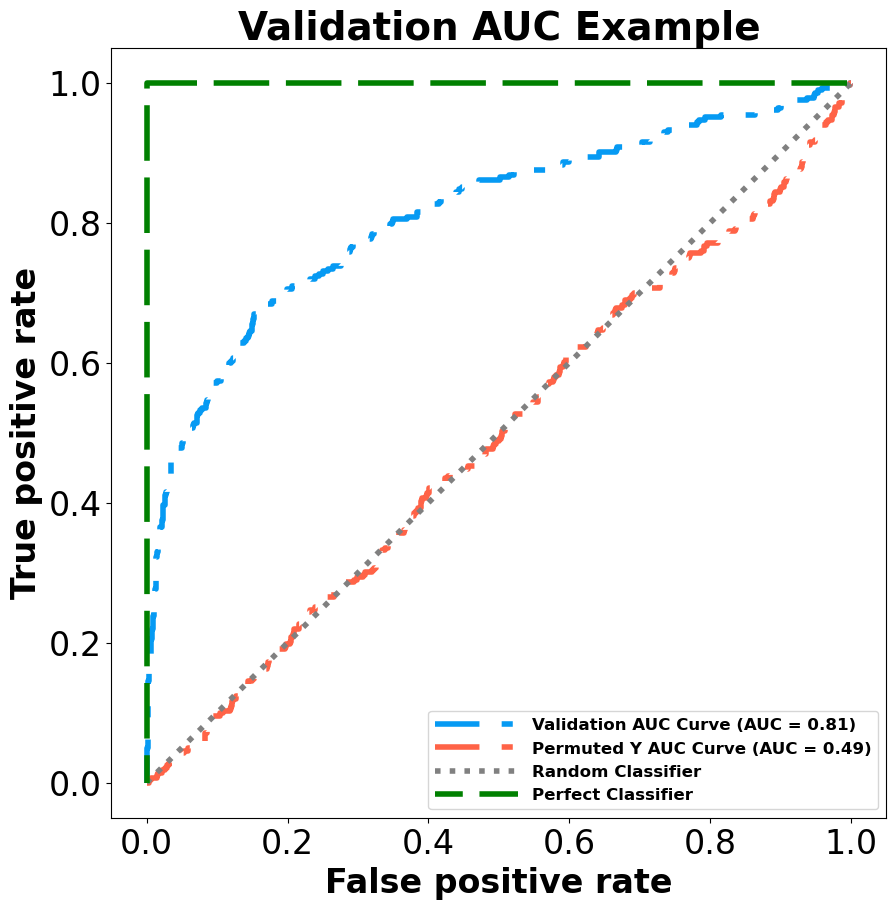

In [18]:
fig = plt.figure(figsize =(10, 10))

plt.plot(fpr, tpr, color='#069AF3', label='Validation AUC Curve (AUC = %0.2f)' % (auc_score), linewidth = 4, dashes=[8, 4, 2, 4, 2, 4])
plt.plot(fpr_perm, tpr_perm, color='tomato', label='Permuted Y AUC Curve (AUC = %0.2f)' % (auc_score_perm), linewidth = 4, dashes=[8, 4, 2, 4, 2, 4])
plt.plot([0, 1], [0, 1], linestyle=':', color='gray', linewidth=4, label='Random Classifier')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=(5, (10, 3)), color='green', linewidth = 4, label='Perfect Classifier')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.title('Validation AUC Example', fontweight='bold', fontsize=28)
plt.xlabel('False positive rate', fontweight='bold', fontsize=24)
plt.ylabel('True positive rate', fontweight='bold', fontsize=24)
plt.legend(loc="lower right", prop={'size': 12, 'weight':'bold'}, handlelength=5)
plt.show()

### Standard Cross Validation

In [19]:
# SCV can take ~20 min, can use the pre-saved DF in next cell!
scv_df = pd.DataFrame(columns=['AUCs','PermYAUCs','F1s','Precisions','Recalls','TPRs','FPRs','FPRperms','TPRperms'])

# number of iterations
outer_loop = 10
inner_loop = 10

all_tts_aucs = []
all_tts_permy_aucs = []
all_tts_f1s = []
all_tts_percisions =[]
all_tts_recalls = []
all_tts_fprs = []
all_tts_tprs = []
all_tts_permy_fprs = []
all_tts_permy_tprs = []

#  make unshuffled dataset
# Shuffle dataset to eliminate batch effect
features = np.array(list(df.Vectors.values))
labels = np.array(list(df.Y2H_score.values))

for o_its in tqdm(range(outer_loop)): # shuffle dataset 
    # shuffle data and change the seed each time
    np.random.seed(o_its)
    
    # create new shuffled indicies
    indices = np.arange(features.shape[0]) 
    np.random.shuffle(indices)
    features = features[indices]
    labels = labels[indices]

    # save the scores from AUCs
    tts_aucs = []   
    tts_permy_aucs = []
    tts_f1s = []
    tts_percisions =[]
    tts_recalls = []
    tts_fprs = []
    tts_tprs = []
    tts_permy_fprs = []
    tts_permy_tprs = []
    
    for i_its in range(inner_loop): # shuffle each tts
        # TTS + perm y set
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=i_its) # change seed
        y_test_perm = np.random.binomial(n=1, p=(Counter(y_test)[1.0]/len(y_test)), size=[len(y_test)]) # random ys

        # train XGB
        xgb_cl = XGBClassifier(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate)
        xgb_cl.fit(X_train,y_train)

        # test XGB + permy
        test_pred = xgb_cl.predict(X_test)
        pred_proba = xgb_cl.predict_proba(X_test)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba)
        tts_fprs.append(fpr)
        tts_tprs.append(tpr)

        test_pred_perm = xgb_cl.predict(X_test)
        pred_proba_perm = xgb_cl.predict_proba(X_test)[:,1]
        fpr_perm, tpr_perm, _ = metrics.roc_curve(y_test_perm, pred_proba_perm)
        tts_permy_fprs.append(fpr_perm)
        tts_permy_tprs.append(tpr_perm)

        auc_score = metrics.roc_auc_score(y_test,pred_proba)
        auc_score_perm = metrics.roc_auc_score(y_test_perm,pred_proba_perm)
        f1_score =  metrics.f1_score(y_test,test_pred)
        precision = metrics.precision_score(y_test,test_pred)
        recall = metrics.recall_score(y_test,test_pred)
        
        tts_aucs.append(auc_score)
        tts_permy_aucs.append(auc_score_perm)
        tts_f1s.append(f1_score)
        tts_percisions.append(precision)
        tts_recalls.append(recall)
        
    # Define a common set of FPR values for plotting
    common_fpr = np.linspace(0, 1, 100)
    common_fpr_perm = np.linspace(0, 1, 100)
    interp_tpr = []
    interp_tpr_perm = []
    
    # Interpolate TPR values for each fold
    for i in range(len(tts_fprs)):
        interp_tpr.append(np.interp(common_fpr, tts_fprs[i], tts_tprs[i]))
        interp_tpr_perm.append(np.interp(common_fpr_perm, tts_permy_fprs[i], tts_permy_tprs[i]))
    # Calculate the mean of the interpolated TPR values
    mean_tpr = np.mean(interp_tpr, axis=0)
    mean_tpr_perm = np.mean(interp_tpr_perm, axis=0)

    all_tts_aucs.append(np.mean(tts_aucs))
    all_tts_permy_aucs.append(np.mean(tts_permy_aucs))
    all_tts_f1s.append(np.mean(tts_f1s))
    all_tts_percisions.append(np.mean(tts_percisions))
    all_tts_recalls.append(np.mean(tts_recalls))
    all_tts_fprs.append(common_fpr)
    all_tts_tprs.append(mean_tpr)
    all_tts_permy_fprs.append(common_fpr_perm)
    all_tts_permy_tprs.append(mean_tpr_perm)
    print('Outer Loop #' + str(o_its)+ ' Done')

# save data
scv_df['AUCs'] = all_tts_aucs
scv_df['PermYAUCs'] = all_tts_permy_aucs
scv_df['F1s'] = all_tts_f1s
scv_df['Precisions'] = all_tts_percisions
scv_df['Recalls'] = all_tts_recalls
scv_df['FPRs'] = all_tts_fprs
scv_df['TPRs'] = all_tts_tprs
scv_df['FPRperms'] = all_tts_permy_fprs
scv_df['TPRperms'] = all_tts_permy_tprs
# scv_df.to_pickle('../Results/MutInt_standard_cross_validation_example_results.pkl')

 10%|█         | 1/10 [00:58<08:45, 58.42s/it]

Outer Loop #0 Done


 20%|██        | 2/10 [01:57<07:48, 58.53s/it]

Outer Loop #1 Done


 30%|███       | 3/10 [02:55<06:50, 58.62s/it]

Outer Loop #2 Done


 40%|████      | 4/10 [03:54<05:51, 58.62s/it]

Outer Loop #3 Done


 50%|█████     | 5/10 [04:53<04:53, 58.75s/it]

Outer Loop #4 Done


 60%|██████    | 6/10 [05:51<03:54, 58.55s/it]

Outer Loop #5 Done


 70%|███████   | 7/10 [06:49<02:55, 58.36s/it]

Outer Loop #6 Done


 80%|████████  | 8/10 [07:47<01:56, 58.15s/it]

Outer Loop #7 Done


 90%|█████████ | 9/10 [08:44<00:58, 58.01s/it]

Outer Loop #8 Done


100%|██████████| 10/10 [09:42<00:00, 58.27s/it]

Outer Loop #9 Done


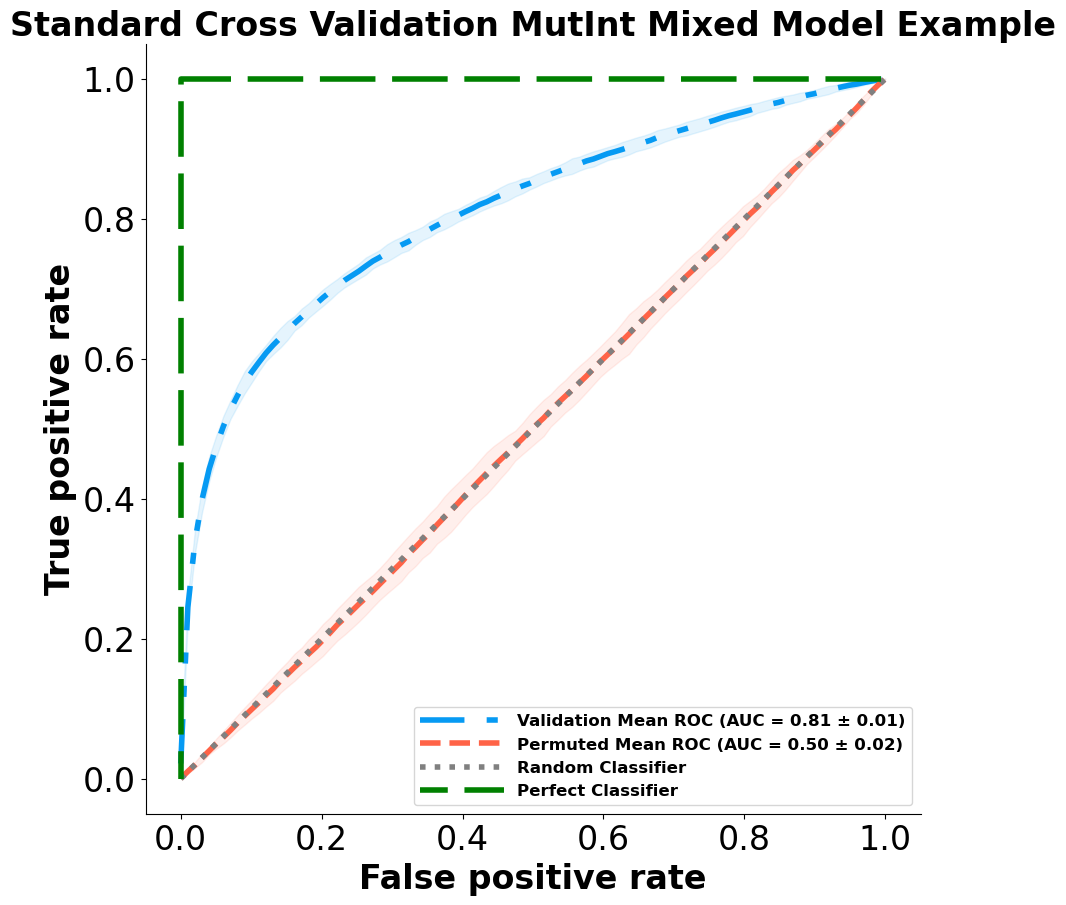

In [20]:
# Load pickle from example OR change to your SCV results
scv_df = pd.read_pickle('../Results/MutInt_standard_cross_validation_example_results.pkl')

val_fpr = scv_df.FPRs.values
val_tpr = scv_df.TPRs.values
fpr_perm = scv_df.FPRperms.values
tpr_perm = scv_df.TPRperms.values
mean_auc = np.mean(scv_df.AUCs.values)
std_auc = np.std(scv_df.AUCs.values)
mean_auc_perm = np.mean(scv_df.PermYAUCs.values)
std_auc_perm = np.std(scv_df.PermYAUCs.values)

# Define a common set of FPR values
common_fpr = np.linspace(0, 1, 100)
common_fpr_perm = np.linspace(0, 1, 100)

interp_tpr = []
interp_tpr_perm = []

# Interpolate TPR values for each fold
for i in range(len(val_fpr)):
    interp_tpr.append(np.interp(common_fpr, val_fpr[i], val_tpr[i]))
    interp_tpr_perm.append(np.interp(common_fpr_perm, fpr_perm[i], tpr_perm[i]))

# Calculate the mean and standard deviation of the interpolated TPR values
mean_tpr = np.mean(interp_tpr, axis=0)
std_tpr = np.std(interp_tpr, axis=0)
mean_tpr_perm = np.mean(interp_tpr_perm, axis=0)
std_tpr_perm = np.std(interp_tpr_perm, axis=0)

# Create the plot
fig = plt.figure(figsize =(10, 10))
plt.plot(common_fpr, mean_tpr, color='#069AF3', label='Validation Mean ROC (AUC = %0.2f \u00B1 %0.2f)' % (mean_auc, 2*std_auc), linewidth = 4, dashes=[8, 4, 2, 4, 2, 4])
plt.fill_between(common_fpr, (mean_tpr - 2*std_tpr), (mean_tpr + 2*std_tpr), color='#069AF3', alpha=0.1)
plt.plot(common_fpr_perm, mean_tpr_perm, color='tomato', label='Permuted Mean ROC (AUC = %0.2f \u00B1 %0.2f)' % (mean_auc_perm, 2*std_auc_perm), linewidth = 4, linestyle='--')
plt.fill_between(common_fpr_perm, (mean_tpr_perm - 2*std_tpr_perm), (mean_tpr_perm + 2*std_tpr_perm), color='tomato', alpha=0.1)

# Customize the plot
plt.plot([0, 1], [0, 1], linestyle=':', color='gray', linewidth=4, label='Random Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 0, 1], [0, 1, 1], linestyle=(5, (10, 3)), color='green', linewidth = 4, label='Perfect Classifier')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.title('Standard Cross Validation MutInt Mixed Model Example', fontweight='bold', fontsize=24)
plt.xlabel('False positive rate', fontweight='bold', fontsize=24)
plt.ylabel('True positive rate', fontweight='bold', fontsize=24)
plt.legend(loc="lower right", prop={'size': 12, 'weight':'bold'}, handlelength=5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()